In [2]:
###simple neural architecture 


import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
import pandas as pd
%matplotlib inline




In [3]:
####importing data

# Import MNIST data

mnist = fetch_mldata('MNIST original')

In [26]:
 ##  there are 1797 images (8 by 8 images for a dimensionality of 64)

X_image = mnist.data[0:100,]
X_label = mnist.target[0:100,]


X_label = X_label.reshape(X_label.shape[0],1)    
print("Image Data Shape" , X_image.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", X_label.shape)


('Image Data Shape', (100, 784))
('Label Data Shape', (100, 1))


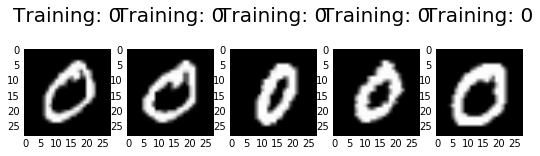

In [4]:
##visualising data

import matplotlib.pyplot as plt


plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_image[0:5], X_label[0:5])):
    plt.subplot(1, 11, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [27]:
###reshaping input
X_layer = list()
for m in (X_image):
    X_layer.append(m.reshape(28,28))
X_layer = np.array(X_layer)
X_layer = X_layer.reshape(X_layer.shape[0],X_layer.shape[1],X_layer.shape[2],1)
X_layer.shape

(100, 28, 28, 1)

In [31]:
##initialisng default values
learning_rate = 0.01
epochs = 50

W = np.random.randn(2, 2, 1, 1)
b = np.random.randn(1, 1, 1, 1)
####conv1 parameters
hparameters_1 = {"pad" : 2,
               "stride": 1}
np.random.seed(1)
##pooling parameters
hparameters_2 = {"stride" : 2, "f": 3}

###initialisng weights and bias for fully connected layer
W_full_connected = np.random.rand(10,225)
B_full_connected = np.random.rand(10,1)

In [29]:
####flatten function
def flatten_input(A):
    A = A.flatten()
    return A 
   



In [30]:
###weigths for fully connected layer reshaping

def fully_connected(data, W,B):
    
    fully_connected_array = (np.dot(W,data ) + B)
    
    return fully_connected_array
      
    

In [9]:
#### softmax function
def softmax(x):
    
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)



In [10]:
##converting y[i] to one hot encoding
def y_hot_encoding(y):
    
    nb_classes = 10

    y = y.astype(int)

    one_hot_targets = np.eye(nb_classes)[y]
    return one_hot_targets


In [11]:
##net loss after one example
def loss(predicted_output, y) :
    loss = np.square(predicted_output.T- y).sum() * 0.5
    return loss


    

In [12]:
###cross entropy loss
def loss_entropy(A,Y):
   
    return -np.sum(np.multiply(np.log(A),Y))

In [13]:
#####calculating gradients for mean loss
###gradeint for fully connected W function
def delta_W(final_prediction, one_hot_targets,A_flatten):
    c = np.multiply(np.subtract(final_prediction, one_hot_targets.T), np.multiply(final_prediction,(1-final_prediction)))
    delta_w = c.dot(A_flatten.T)
    delta_b = c
    delta_Y = c
    return delta_w,delta_b,delta_Y


        


In [14]:

def zero_pad(X, pad):
    ### input shape X =  ( n_H, n_W, n_C), padding number
    
    X_pad = np.pad(X,((pad,pad),(pad,pad),(0,0)),'constant',constant_values = 0)  ##padding in horizontal & vertical
    
    
    return X_pad

In [15]:


def conv_single_step(a_slice_prev, W, b):
    ## input shape of slice = filter size, b based on number of filter
    ##Z --   convolving the sliding window (W, b) on a slice x of the input data
    
    # Element-wise product between a_slice and W. Add bias. and sum
    s = np.sum(np.multiply(a_slice_prev, W) + b)
    
    

    return s

In [16]:


def conv_forward(A_prev, W, b, hparameters):
    ##A_prev = previous layer output shape[ n_H_prev, n_W_prev, n_C_prev],W is filter (f, f, n_C_prev, n_C)
    ##b biases, output Z is n_H, n_W, n_C where n_H = n-f+2p/S +1, n_W = n-f+2p/s +1
    
    
    # A'prev dimensions
    ( n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # W dimensions
    (f, f, n_C_prev, n_C) = W.shape

    # information from "hparameters" 
    stride = hparameters['stride']
    pad   = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume 
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # Initialize the output volume Z with zeros
    Z = np.zeros((n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
                                   
    a_prev_pad = A_prev_pad                  
    for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    # corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    # cutting 3D slice 
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    Z[h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    

    # Making sure  output shape is correct
    assert(Z.shape == (n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [17]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    ###input  size [h,w,no of previous inputs]
    
    
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros(( n_H, n_W, n_C))              
    
   
                            
    for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = (h)*stride
                    vert_end = vert_start+f
                    horiz_start = (w)*stride
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    #print(a_prev_slice.shape)
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[ h, w, c] = np.max(a_prev_slice)
                    
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == ( n_H, n_W, n_C))
    
    return A, cache


In [18]:

def create_mask_from_window(x):
    #### boolean form to identify max value in matrix
    
    
    mask = (x==np.max(x))
   
    
    return mask

In [19]:
def pool_backward(dA, cache, mode = "max"):
    
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
                        
     # select training example from A_prev (≈1 line)
    a_prev = A_prev
    for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[ h, w, c])
                        
                    
                        
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [20]:
#######backward convolutional propagation
def conv_backward(dZ, cache):
    
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
                       
        
        
    da_prev_pad = dA_prev_pad
        
    for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = A_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[ h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[ h, w, c]   ###dw = x*dZ
                    db[:,:,:,c] += dZ[ h, w, c]    ###db = dZ
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
    dA_prev[ :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [32]:
total_loss = []

total_predictions = []


for j in range(epochs):
    for  i  in range (X_layer.shape[0]):
        print j,i
    ##forward convolution
        A_conv1, cache_conv = conv_forward(X_layer[i], W, b, hparameters_1)
    
    ###pooling forward
        A_pool1, cache = pool_forward(A_conv1, hparameters_2, mode = "max")
    
    ##flatten image
        A_flatten = flatten_input(A_pool1)
        A_flatten = A_flatten.reshape(A_flatten.shape[0],1)
    
    ##fully connected layer
        A_fully_connected  = fully_connected(A_flatten,W_full_connected,B_full_connected)
    
    ##softmax transformation
        A_softmax_output = softmax(A_fully_connected)
        total_predictions.append(A_softmax_output.argmax())
    ##output y one hot encoding
        y_output = y_hot_encoding(X_label[i])
    
    ##loss calculation
        A_loss = loss(A_softmax_output,y_output)
        total_loss.append(A_loss)
    
    ##fully connected backward propagation
        A_fully_connected_delta_W, A_fully_connected_delta_B, delta_Y = delta_W(A_softmax_output,y_output,A_flatten)
    
    ##reshaping again for pool gradient calculation
        delta_f = A_fully_connected_delta_W.T.dot(delta_Y)
        delta_f = delta_f.reshape(15,15,1)
    
    ####pooling backward prop
        A_backprop_pool = pool_backward(delta_f,cache,mode = "max")
    
    ##convolutional backward propagation
        dA_prev,dW_conv,db_conv = conv_backward(A_backprop_pool,cache_conv)
    
    ##updating weights
        W_full_connected = W_full_connected - learning_rate*A_fully_connected_delta_W
        B_full_connected = B_full_connected - learning_rate*A_fully_connected_delta_B


        ###conv layer weight updattes
        W = W - learning_rate*dW_conv
        b = b - learning_rate*db_conv
        
    
    

    
    

    
    
    
    
    

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30
17 31


29 56
29 57
29 58
29 59
29 60
29 61
29 62
29 63
29 64
29 65
29 66
29 67
29 68
29 69
29 70
29 71
29 72
29 73
29 74
29 75
29 76
29 77
29 78
29 79
29 80
29 81
29 82
29 83
29 84
29 85
29 86
29 87
29 88
29 89
29 90
29 91
29 92
29 93
29 94
29 95
29 96
29 97
29 98
29 99
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
31 18
31 19
31 20
31 21
31 22
31 23
31 24
31 25


43 48
43 49
43 50
43 51
43 52
43 53
43 54
43 55
43 56
43 57
43 58
43 59
43 60
43 61
43 62
43 63
43 64
43 65
43 66
43 67
43 68
43 69
43 70
43 71
43 72
43 73
43 74
43 75
43 76
43 77
43 78
43 79
43 80
43 81
43 82
43 83
43 84
43 85
43 86
43 87
43 88
43 89
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
43 99
44 0
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 15
44 16
44 17
44 18
44 19
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 29
44 30
44 31
44 32
44 33
44 34
44 35
44 36
44 37
44 38
44 39
44 40
44 41
44 42
44 43
44 44
44 45
44 46
44 47
44 48
44 49
44 50
44 51
44 52
44 53
44 54
44 55
44 56
44 57
44 58
44 59
44 60
44 61
44 62
44 63
44 64
44 65
44 66
44 67
44 68
44 69
44 70
44 71
44 72
44 73
44 74
44 75
44 76
44 77
44 78
44 79
44 80
44 81
44 82
44 83
44 84
44 85
44 86
44 87
44 88
44 89
44 90
44 91
44 92
44 93
44 94
44 95
44 96
44 97
44 98
44 99
45 0
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
45 11
45 12
45 13
45 14
45 15
45 16
45 17


In [33]:
from sklearn.metrics import confusion_matrix
finallll_prediction = np.array(total_predictions[-100:])
output_original = X_label[0:100]

test_confusion = confusion_matrix(output_original,finallll_prediction)
test_confusion.view()
######accuracy around 80% percent on  100data

array([[87,  1,  6,  6],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])